In [1]:
from pathlib import Path

# === CONFIGURACIÓN ===

# Pon aquí la ruta a tu foto original (JPG o PNG).
# Ejemplos:
# image_path = Path('mi_foto.jpg')
# image_path = Path('/ruta/completa/a/mi_foto.png')

image_path = Path('/Users/amaiamartingrande/Desktop/WORKSPACE/machine_leatning2/Rafael Nadal Wimbledon 2022.jpg')  # <--- CAMBIA ESTE NOMBRE POR TU ARCHIVO

# Define los valores de k (al menos 2 valores)
ks = [2, 4, 8]  # puedes cambiarlo, por ejemplo [3, 6] o [2, 5, 10]

# Carpeta donde se guardarán las imágenes de salida
out_dir = Path('/Users/amaiamartingrande/Desktop/WORKSPACE/machine_leatning2/imagenes_clusterizadas')
out_dir.mkdir(exist_ok=True)

print('Usando imagen:', image_path.resolve())
print('Ks:', ks)

Usando imagen: /Users/amaiamartingrande/Desktop/WORKSPACE/machine_leatning2/Rafael Nadal Wimbledon 2022.jpg
Ks: [2, 4, 8]


In [2]:
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import os

# Para que los gráficos se vean dentro del notebook
%matplotlib inline

def cargar_imagen(path: Path):
    """Carga la imagen y la convierte a RGB."""
    if not path.exists():
        raise FileNotFoundError(f'No se encontró la imagen: {path}')
    img = Image.open(path).convert('RGB')
    return img

def clusterizar_kmeans(img: Image.Image, k: int):
    """
    Aplica K-Means sobre los píxeles de la imagen en el espacio RGB y devuelve:
    - imagen clusterizada (cuantizada)
    - paleta de colores (centroides)
    - etiquetas de cluster por píxel
    """
    arr = np.array(img, dtype=np.float32)
    h, w, c = arr.shape
    flat = arr.reshape(-1, 3)

    # KMeans
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(flat)
    palette = km.cluster_centers_

    # Reconstruir la imagen usando los centroides
    quant_flat = palette[labels].astype(np.uint8)
    quant_img = quant_flat.reshape(h, w, 3)
    return Image.fromarray(quant_img), palette, labels

def guardar_con_calidad(img: Image.Image, path_out: Path, formato='JPEG', calidad=95):
    """
    Guarda la imagen con formato y calidad controlados 
    (así podemos comparar tamaños de archivo de forma justa).
    """
    formato = formato.upper()
    if formato == 'JPEG':
        img.save(path_out, format=formato, quality=calidad, optimize=True)
    elif formato == 'PNG':
        img.save(path_out, format=formato, optimize=True)
    else:
        img.save(path_out)

def tamano_archivo_bytes(path: Path) -> int:
    """Devuelve el tamaño del archivo en bytes."""
    return os.path.getsize(path)

def formato_bytes(n):
    """Convierte bytes a una cadena legible (KB, MB)."""
    step = 1024.0
    if n < step:
        return f"{n} B"
    n /= step
    if n < step:
        return f"{n:.2f} KB"
    n /= step
    return f"{n:.2f} MB"

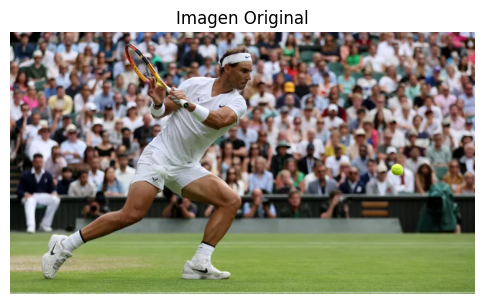

Guardado original en: /Users/amaiamartingrande/Desktop/WORKSPACE/machine_leatning2/imagenes_clusterizadas/original_estandar.jpg
Tamaño original: 126.61 KB


In [3]:
# Cargar y mostrar imagen original
original = cargar_imagen(image_path)

plt.figure(figsize=(6, 6))
plt.imshow(original)
plt.axis('off')
plt.title('Imagen Original')
plt.show()

# Guardar una copia "estándar" para medir tamaño base
original_out = out_dir / 'original_estandar.jpg'
guardar_con_calidad(original, original_out, formato='JPEG', calidad=95)
orig_size = tamano_archivo_bytes(original_out)

print('Guardado original en:', original_out)
print('Tamaño original:', formato_bytes(orig_size))

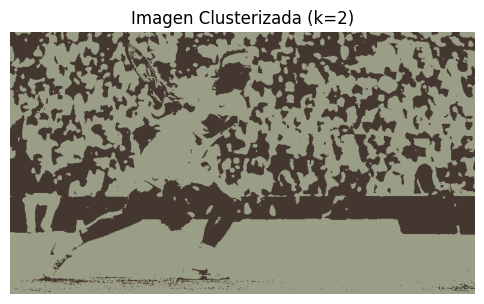

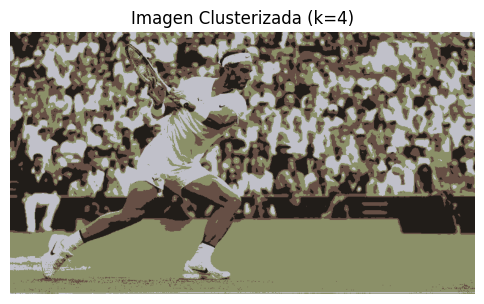

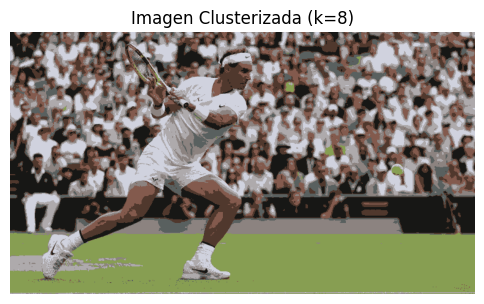

,k,archivo_clusterizado,tamano_clusterizado_bytes,tamano_clusterizado,tamano_original_bytes,tamano_original,factor_compresion (orig/cluster),reduccion_%
0,2,/Users/amaiamartingrande/Desktop/WORKSPACE/mac...,120573,117.75 KB,129650,126.61 KB,1.075,7.00
1,4,/Users/amaiamartingrande/Desktop/WORKSPACE/mac...,157982,154.28 KB,129650,126.61 KB,0.821,-21.85
2,8,/Users/amaiamartingrande/Desktop/WORKSPACE/mac...,158427,154.71 KB,129650,126.61 KB,0.818,-22.20


In [4]:
resultados = []

for k in ks:
    # Clusterizar con K-Means
    qimg, palette, labels = clusterizar_kmeans(original, k)
    
    # Guardar imagen clusterizada
    out_path = out_dir / f'cluster_k{k}.jpg'
    guardar_con_calidad(qimg, out_path, formato='JPEG', calidad=95)
    size_k = tamano_archivo_bytes(out_path)
    
    # Factor de compresión = tamaño_original / tamaño_clusterizado
    comp_factor = orig_size / size_k if size_k > 0 else float('inf')
    reduccion_pct = (1 - (size_k / orig_size)) * 100
    
    resultados.append({
        'k': k,
        'archivo_clusterizado': str(out_path),
        'tamano_clusterizado_bytes': size_k,
        'tamano_clusterizado': formato_bytes(size_k),
        'tamano_original_bytes': orig_size,
        'tamano_original': formato_bytes(orig_size),
        'factor_compresion (orig/cluster)': round(comp_factor, 3),
        'reduccion_%': round(reduccion_pct, 2),
    })

    # Mostrar la imagen clusterizada
    plt.figure(figsize=(6, 6))
    plt.imshow(qimg)
    plt.axis('off')
    plt.title(f'Imagen Clusterizada (k={k})')
    plt.show()

# Crear DataFrame con los resultados
df = pd.DataFrame(resultados)
df

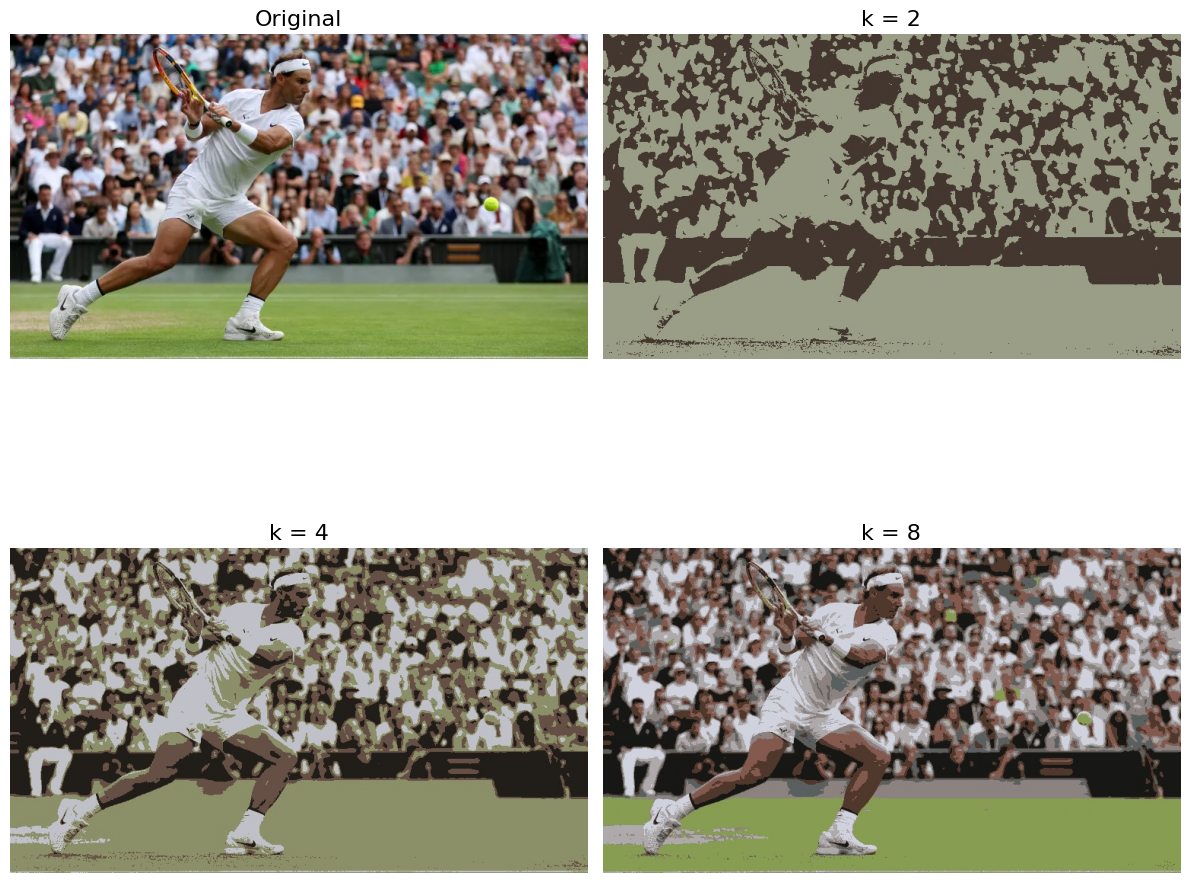

In [6]:
import matplotlib.pyplot as plt

# Cargar imágenes clusterizadas generadas previamente
imagenes = [('Original', original)]

for k in ks:
    img_cluster = Image.open(out_dir / f'cluster_k{k}.jpg')
    imagenes.append((f'k = {k}', img_cluster))

# Crear figura
n = len(imagenes)
cols = 2
rows = (n + 1) // 2

plt.figure(figsize=(12, 6 * rows))

for i, (titulo, img) in enumerate(imagenes, 1):
    plt.subplot(rows, cols, i)
    plt.imshow(img)
    plt.title(titulo, fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()